In [1]:
# CELL 1: Setup & Imports
"""
ROI Creation for Longitudinal Hemispherectomy Study
====================================================
Creates functional ROIs using Leave-One-Out approach in ses-01
Based on Liu et al. 2025 methodology

Author: Claire Simmons
Date: October 2025
"""

import numpy as np
import nibabel as nib
import pandas as pd
from scipy import ndimage
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
import os
warnings.filterwarnings('ignore')

print("✓ Imports loaded successfully")

✓ Imports loaded successfully


In [2]:
# CELL 2: Configuration & Paths (UPDATED)
"""
Define all paths, subjects, and ROI configuration
"""

# Base paths
BASE_DIR = Path('/user_data/csimmon2/long_pt')

# Subject configuration
SUBJECTS = {
    'sub-004': {
        'patient_code': 'UD',
        'resection': 'Right posterior VOTC',
        'intact_hemisphere': 'left',
        'sessions': [1, 2, 3, 5, 6]
    },
    'sub-007': {
        'patient_code': 'OT', 
        'resection': 'Left anterior temporal',
        'intact_hemisphere': 'left',
        'sessions': [1, 3, 4]
    },
    'sub-021': {
        'patient_code': 'TC',
        'resection': 'Left posterior VOTC & parietal',
        'intact_hemisphere': 'right',
        'sessions': [1, 2, 3]
    }
}

# ROI Configuration - Maps to Julian parcels
ROI_CONFIG = {
    'FFA': {
        'cope': 6,
        'contrast': 'Face > All',
        'parcel_prefix': 'FFA'  # Uses lFFA, rFFA
    },
    'OFA': {
        'cope': 6,
        'contrast': 'Face > All',
        'parcel_prefix': 'OFA'  # Uses lOFA, rOFA
    },
    'PFS': {
        'cope': 6,  # Faces (also object-responsive)
        'contrast': 'Face > All',
        'parcel_prefix': 'PFS'  # Uses lPFS, rPFS
    },
    'LO': {
        'cope': 8,
        'contrast': 'Object > All',
        'parcel_prefix': 'LO'  # Uses lLO, rLO
    },
    'PPA': {
        'cope': 7,
        'contrast': 'House > All',
        'parcel_prefix': 'PPA'  # Uses lPPA, rPPA
    },
    'OPA': {
        'cope': 7,
        'contrast': 'House > All',
        'parcel_prefix': 'OPA'  # Uses lOPA, rOPA
    }
}

# Analysis parameters
HEMISPHERES = ['left', 'right']
SPHERE_RADII = [6, 8, 10]  # mm
Z_THRESHOLD = 2.3
SESSION = 'ses-01'
N_RUNS = 4
PERCENTILE = 95  # Top 5% of voxels within parcel

print(f"Configuration loaded:")
print(f"  Subjects: {list(SUBJECTS.keys())}")
print(f"  ROIs: {list(ROI_CONFIG.keys())}")
print(f"  Hemispheres: {HEMISPHERES}")
print(f"  Sphere radii: {SPHERE_RADII} mm")
print(f"  Z threshold: {Z_THRESHOLD}")
print(f"  Top voxel percentile: {PERCENTILE}")

Configuration loaded:
  Subjects: ['sub-004', 'sub-007', 'sub-021']
  ROIs: ['FFA', 'OFA', 'PFS', 'LO', 'PPA', 'OPA']
  Hemispheres: ['left', 'right']
  Sphere radii: [6, 8, 10] mm
  Z threshold: 2.3
  Top voxel percentile: 95



sub-004 (UD):
  Left VTOC: 261,457 voxels
  Right VTOC: 246,180 voxels

sub-007 (OT):
  Left VTOC: 252,710 voxels
  Right VTOC: 325,131 voxels

sub-021 (TC):
  Left VTOC: 208,637 voxels
  Right VTOC: 254,671 voxels


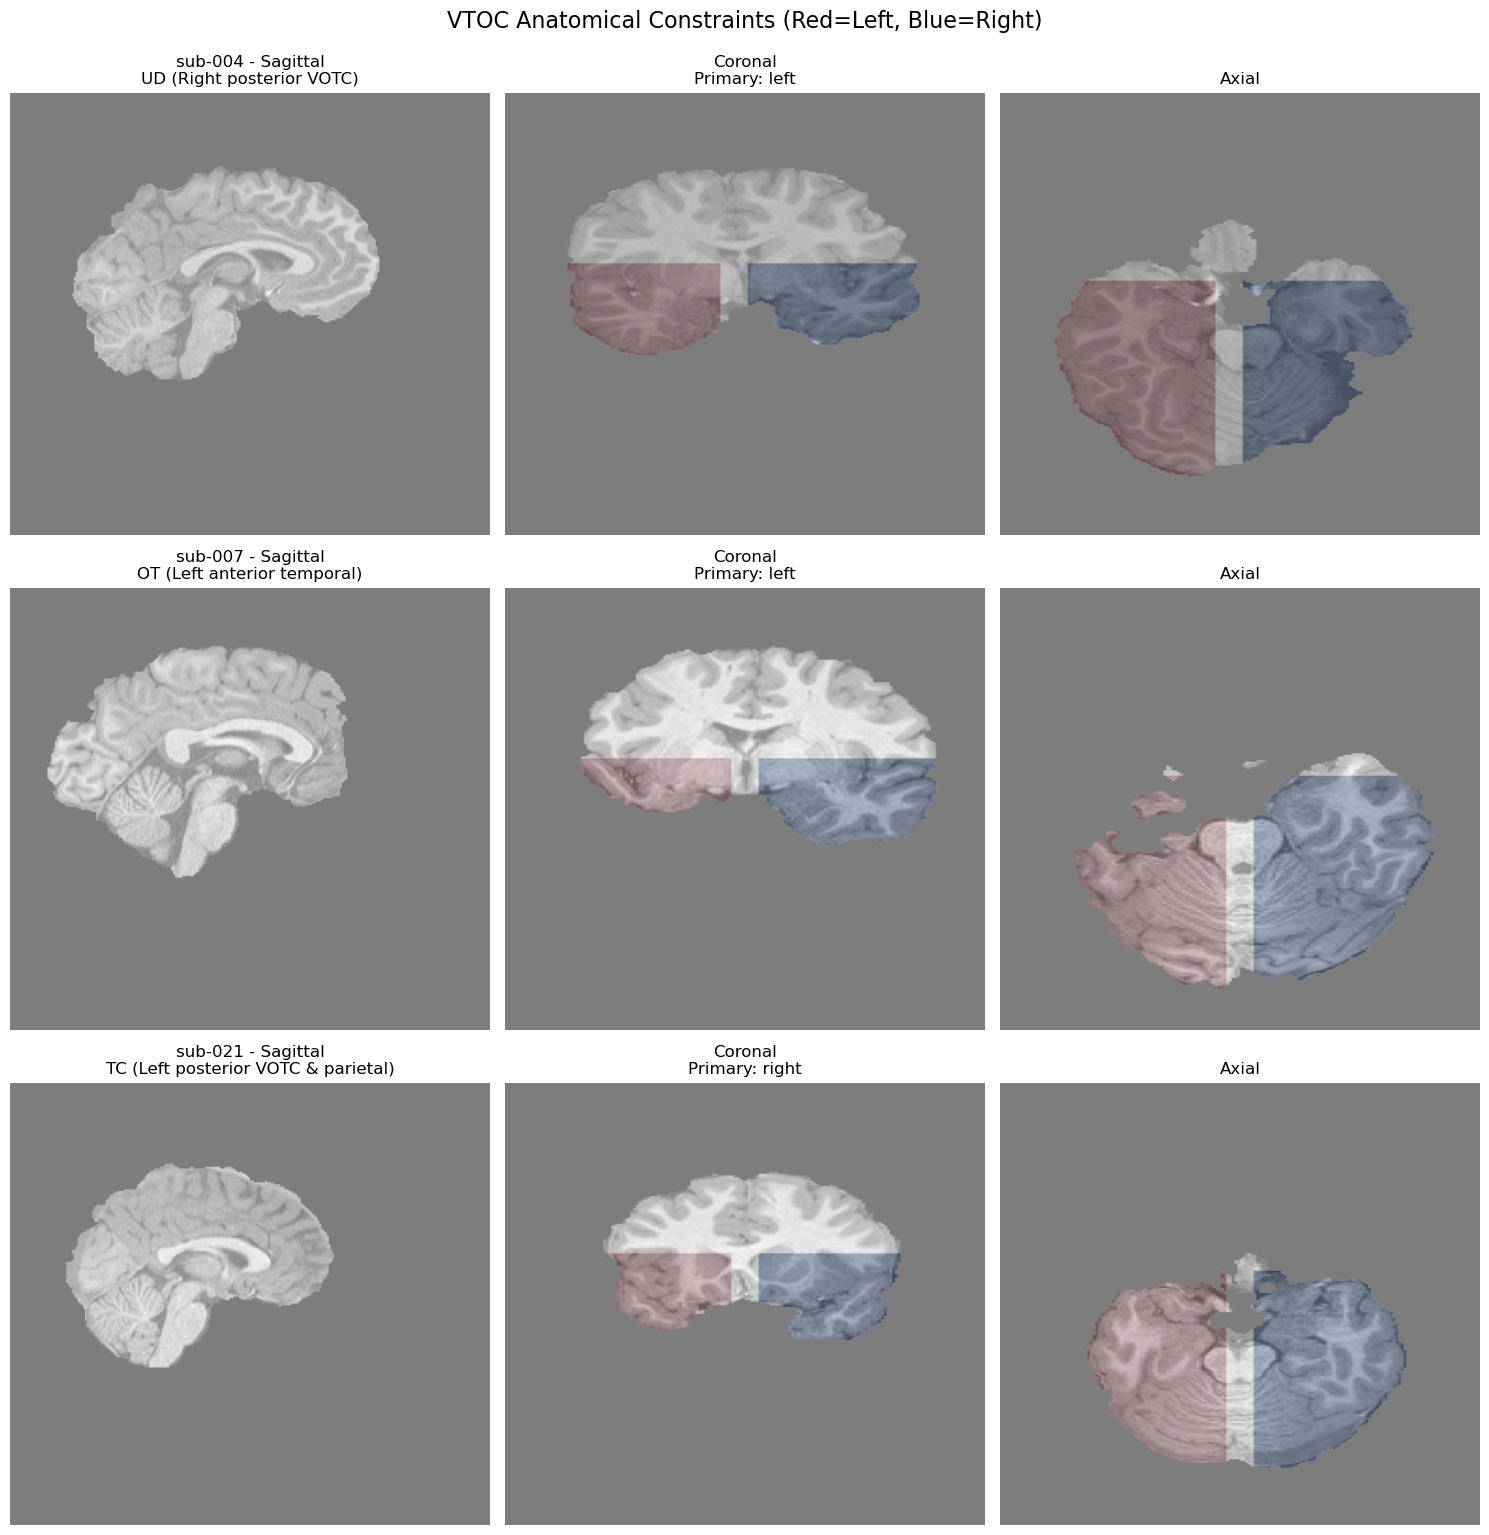


✓ VERIFY: Masks cover fusiform, parahippocampal, lateral occipital, inferior temporal


In [3]:
# CELL 3: Create & Visualize Anatomical Constraints (VTOC)
"""
Create ventral temporal-occipital cortex (VTOC) masks
Visualize on each subject's anatomy for verification
"""

def create_vtoc_mask(anat_img, hemisphere='left'):
    """
    Create VTOC anatomical constraint mask
    
    Parameters:
    -----------
    anat_img : nibabel image
        Anatomical image in subject space
    hemisphere : str
        'left' or 'right'
    
    Returns:
    --------
    vtoc_mask : 3D numpy array
        Binary mask of VTOC
    """
    # Get affine and shape
    affine = anat_img.affine
    shape = anat_img.shape
    
    # Create coordinate grids in mm space
    i, j, k = np.meshgrid(
        np.arange(shape[0]),
        np.arange(shape[1]),
        np.arange(shape[2]),
        indexing='ij'
    )
    
    # Convert voxel indices to mm coordinates
    coords = np.stack([i.ravel(), j.ravel(), k.ravel(), np.ones(i.size)])
    mm_coords = affine @ coords
    X, Y, Z = mm_coords[0].reshape(shape), mm_coords[1].reshape(shape), mm_coords[2].reshape(shape)
    
    # Get brain mask (non-zero voxels)
    brain = anat_img.get_fdata() > 0
    
    # Hemisphere constraint
    if hemisphere == 'left':
        hemi_mask = (X < -5)
    else:
        hemi_mask = (X > 5)
    
    # VTOC boundaries (in mm)
    vtoc_mask = (
        hemi_mask &
        (Y > -110) & (Y < 20) &   # Posterior occipital to anterior temporal
        (Z > -60) & (Z < 30) &    # Inferior to superior
        brain
    )
    
    return vtoc_mask.astype(np.uint8)


# Create and visualize VTOC masks for all subjects
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for idx, (subject, config) in enumerate(SUBJECTS.items()):
    # Load anatomical
    anat_path = BASE_DIR / subject / SESSION / 'anat' / f'{subject}_{SESSION}_T1w_brain.nii.gz'
    anat_img = nib.load(anat_path)
    anat_data = anat_img.get_fdata()
    
    # Create masks for both hemispheres
    left_mask = create_vtoc_mask(anat_img, 'left')
    right_mask = create_vtoc_mask(anat_img, 'right')
    
    # Get middle slices
    mid_sag = anat_data.shape[0] // 2
    mid_cor = anat_data.shape[1] // 2  
    mid_ax = anat_data.shape[2] // 2
    
    # Sagittal view
    ax = axes[idx, 0]
    ax.imshow(np.rot90(anat_data[mid_sag, :, :]), cmap='gray', aspect='auto')
    ax.imshow(np.rot90(left_mask[mid_sag, :, :]), cmap='Reds', alpha=0.3, aspect='auto')
    ax.imshow(np.rot90(right_mask[mid_sag, :, :]), cmap='Blues', alpha=0.3, aspect='auto')
    ax.set_title(f'{subject} - Sagittal\n{config["patient_code"]} ({config["resection"]})')
    ax.axis('off')
    
    # Coronal view
    ax = axes[idx, 1]
    ax.imshow(np.rot90(anat_data[:, mid_cor, :]), cmap='gray', aspect='auto')
    ax.imshow(np.rot90(left_mask[:, mid_cor, :]), cmap='Reds', alpha=0.3, aspect='auto')
    ax.imshow(np.rot90(right_mask[:, mid_cor, :]), cmap='Blues', alpha=0.3, aspect='auto')
    ax.set_title(f'Coronal\nPrimary: {config["primary_hemisphere"]}')
    ax.axis('off')
    
    # Axial view
    ax = axes[idx, 2]
    ax.imshow(np.rot90(anat_data[:, :, mid_ax]), cmap='gray', aspect='auto')
    ax.imshow(np.rot90(left_mask[:, :, mid_ax]), cmap='Reds', alpha=0.3, aspect='auto')
    ax.imshow(np.rot90(right_mask[:, :, mid_ax]), cmap='Blues', alpha=0.3, aspect='auto')
    ax.set_title('Axial')
    ax.axis('off')
    
    # Print statistics
    print(f"\n{subject} ({config['patient_code']}):")
    print(f"  Left VTOC: {left_mask.sum():,} voxels")
    print(f"  Right VTOC: {right_mask.sum():,} voxels")

plt.tight_layout()
plt.suptitle('VTOC Anatomical Constraints (Red=Left, Blue=Right)', y=1.02, fontsize=16)
plt.show()

print("\n✓ VERIFY: Masks cover fusiform, parahippocampal, lateral occipital, inferior temporal")

In [5]:
# CELL 4: Define LOO Helper Functions (CORRECTED)
"""
Core functions for Leave-One-Out ROI definition
"""

def get_available_runs(subject, session=SESSION):
    """Get list of available first-level runs for a session"""
    loc_dir = BASE_DIR / subject / session / 'derivatives' / 'fsl' / 'loc'
    runs = sorted([d.name for d in loc_dir.iterdir() if d.name.startswith('run-') and d.is_dir()])
    run_nums = [r.split('-')[1] for r in runs]
    return run_nums

def load_zstat(subject, session, run, cope):
    """
    Load zstat from first-level analysis - REGISTERED TO SES-01 ANATOMICAL SPACE
    
    The zstats are registered by 07_register_zstats.py to:
    {run_dir}/reg_standard/stats/zstat{cope}.nii.gz
    """
    # Registered zstat location (in ses-01 anatomical space)
    zstat_path = (BASE_DIR / subject / session / 'derivatives' / 'fsl' / 'loc' / 
                  f'run-{run}' / '1stLevel.feat' / 'reg_standard' / 'stats' / f'zstat{cope}.nii.gz')
    
    if not zstat_path.exists():
        raise FileNotFoundError(
            f"Registered zstat not found at: {zstat_path}\n"
            f"Make sure 07_register_zstats.py was run for {subject} {session}"
        )
    
    return nib.load(zstat_path)


def find_peak_in_largest_cluster(zstat_data, vtoc_mask, z_threshold=Z_THRESHOLD):
    """
    Find peak voxel in largest cluster above threshold within VTOC
    
    Returns:
    --------
    peak_coords_mm : tuple (x, y, z) in mm, or None if no clusters found
    peak_z_value : float, or None
    cluster_size : int, or None
    """
    # Apply VTOC mask and threshold
    masked_zstat = zstat_data * vtoc_mask
    thresholded = masked_zstat > z_threshold
    
    # Find connected components (clusters)
    labeled, num_clusters = ndimage.label(thresholded)
    
    if num_clusters == 0:
        return None, None, None
    
    # Find largest cluster
    cluster_sizes = [(labeled == i).sum() for i in range(1, num_clusters + 1)]
    largest_cluster_label = np.argmax(cluster_sizes) + 1
    largest_cluster_mask = (labeled == largest_cluster_label)
    
    # Find peak within largest cluster
    cluster_zstats = masked_zstat * largest_cluster_mask
    peak_voxel_idx = np.unravel_index(np.argmax(cluster_zstats), cluster_zstats.shape)
    peak_z_value = cluster_zstats[peak_voxel_idx]
    
    return peak_voxel_idx, peak_z_value, cluster_sizes[largest_cluster_label - 1]


def voxel_to_mm(voxel_coords, affine):
    """Convert voxel coordinates to mm using affine"""
    voxel_homogeneous = np.array([*voxel_coords, 1])
    mm_coords = affine @ voxel_homogeneous
    return tuple(mm_coords[:3])


def create_sphere_roi(center_mm, radius_mm, reference_img):
    """
    Create spherical ROI mask
    
    Parameters:
    -----------
    center_mm : tuple (x, y, z)
        Center coordinates in mm
    radius_mm : float
        Sphere radius in mm
    reference_img : nibabel image
        Reference image for affine and shape
    
    Returns:
    --------
    sphere_mask : nibabel image
        Binary sphere mask
    """
    affine = reference_img.affine
    shape = reference_img.shape
    
    # Create coordinate grids
    i, j, k = np.meshgrid(
        np.arange(shape[0]),
        np.arange(shape[1]),
        np.arange(shape[2]),
        indexing='ij'
    )
    
    # Convert to mm
    coords = np.stack([i.ravel(), j.ravel(), k.ravel(), np.ones(i.size)])
    mm_coords = affine @ coords
    X = mm_coords[0].reshape(shape)
    Y = mm_coords[1].reshape(shape)
    Z = mm_coords[2].reshape(shape)
    
    # Calculate distance from center
    distance = np.sqrt(
        (X - center_mm[0])**2 + 
        (Y - center_mm[1])**2 + 
        (Z - center_mm[2])**2
    )
    
    # Create sphere
    sphere_mask = (distance <= radius_mm).astype(np.uint8)
    
    return nib.Nifti1Image(sphere_mask, affine)


print("✓ Helper functions defined:")
print("  - get_available_runs()")
print("  - load_zstat() [LOADS REGISTERED ZSTATS IN ANATOMICAL SPACE]")
print("  - find_peak_in_largest_cluster()")
print("  - voxel_to_mm()")
print("  - create_sphere_roi()")

✓ Helper functions defined:
  - get_available_runs()
  - load_zstat() [LOADS REGISTERED ZSTATS IN ANATOMICAL SPACE]
  - find_peak_in_largest_cluster()
  - voxel_to_mm()
  - create_sphere_roi()
